# SENTIMENT ANALYSIS


Para entrenar el modelo de análisis de sentimiento, se utilizará el algoritmo Naive Bayes por efectos de cómputo. 

El objetivo es determinar el nivel de percepción positiva que tienen los empleados en relación con la empresa.

## 1. Importar Librerías and Setup

In [1]:
# Procesamiento de Datos y Cómputo
import numpy as np
import pandas as pd
import datetime
import joblib
import os

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Database
import pymssql

# Configure warnings and logging
import warnings
import logging

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)


## 2. Conectar a dataset de entrenamiento

In [2]:
### DATA SOURCE ###

URL = "https://raw.githubusercontent.com/jdranalytics/Portfolio/refs/heads/main/03_people_analytics/00_data_sources/employee_satisfaction_dataset.csv"
URL = pd.read_csv(URL, sep=',', quotechar='"', encoding='utf-8', nrows=10000)


df = pd.DataFrame(URL)
df = df.sample(frac=1).reset_index(drop=True)


df.head(5)

,comment,sentiment,score
0,My manager listens to my feedback and acts on it.,Positive,0
1,"Work-life balance is well-maintained, and I fe...",Positive,1
2,The company truly cares about employee well-be...,Positive,0
3,I feel overworked and underappreciated in my r...,Negative,4
4,My manager listens to my feedback and acts on it.,Positive,1


## 3. Entrenamiento del modelo NB Multinomial

In [3]:

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, ngram_range=(1,10), tokenizer=token.tokenize)
text_counts = cv.fit_transform(df['comment'])

print(df.head(10))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['sentiment'], test_size=0.2, random_state=42
)

# Create and train the MultinomialNB classifier
clf = MultinomialNB().fit(X_train, y_train)

# Make predictions
predicted = clf.predict(X_test)

# Print the accuracy score
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, predicted))


                                             comment sentiment  score
0  My manager listens to my feedback and acts on it.  Positive      0
1  Work-life balance is well-maintained, and I fe...  Positive      1
2  The company truly cares about employee well-be...  Positive      0
3  I feel overworked and underappreciated in my r...  Negative      4
4  My manager listens to my feedback and acts on it.  Positive      1
5  The company truly cares about employee well-be...  Positive      1
6  I don’t have strong feelings about the company...   Neutral      2
7  My manager listens to my feedback and acts on it.  Positive      0
8  I feel overworked and underappreciated in my r...  Negative      4
9  The company truly cares about employee well-be...  Positive      0
MultinomialNB Accuracy: 1.0


## 4. Visualización de Resultados

<Figure size 1000x600 with 0 Axes>

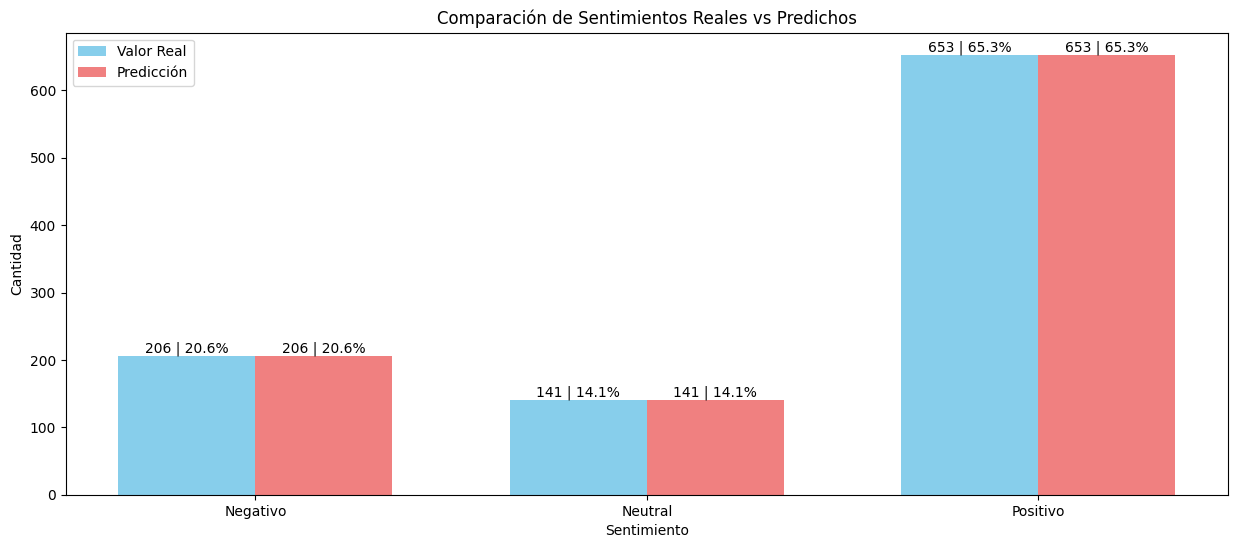


Comparación de predicciones vs valores reales:
     Valor Real Predicción
1501   Negative   Negative
2586    Neutral    Neutral
2653   Positive   Positive
1055   Negative   Negative
705    Positive   Positive
...         ...        ...
4711   Negative   Negative
2313   Positive   Positive
3214   Negative   Negative
2732   Positive   Positive
1926    Neutral    Neutral

[1000 rows x 2 columns]


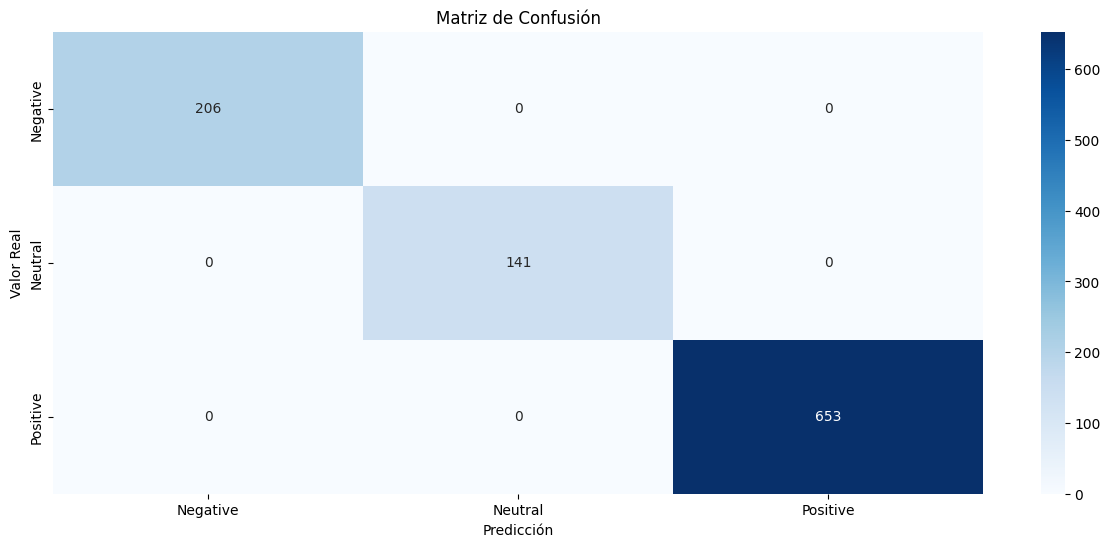

In [4]:

# Create a DataFrame with the comparison
comparison_df = pd.DataFrame({
    'Valor Real': y_test,
    'Predicción': predicted
})

# Create bar chart comparing real vs predicted
plt.figure(figsize=(10, 6))
real_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(predicted).value_counts().sort_index()

# Calculate percentages
real_percentages = (real_counts / real_counts.sum()) * 100
pred_percentages = (pred_counts / pred_counts.sum()) * 100

x = np.arange(len(real_counts))
width = 0.35

# Define sentiment labels
sentiment_labels = ['Negativo', 'Neutral', 'Positivo']
plt.figure(figsize=(15, 6))
# Create bars
bars1 = plt.bar(x - width/2, real_counts, width, label='Valor Real', color='skyblue')
bars2 = plt.bar(x + width/2, pred_counts, width, label='Predicción', color='lightcoral')

# Add percentage labels on top of each bar
for bars in [bars1, bars2]:
    for idx, rect in enumerate(bars):
        height = rect.get_height()
        percentage = real_percentages[idx] if bars == bars1 else pred_percentages[idx]
        count = real_counts[idx] if bars == bars1 else pred_counts[idx]
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{count:,.0f} | {percentage:.1f}%',
                ha='center', va='bottom')

plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Comparación de Sentimientos Reales vs Predichos')
plt.xticks(x, sentiment_labels)
plt.legend()
plt.show()

# Display the comparison DataFrame
print("\nComparación de predicciones vs valores reales:")
print(comparison_df)

# Optional: Create a confusion matrix visualization
plt.figure(figsize=(15, 6))
confusion_matrix = pd.crosstab(comparison_df['Valor Real'], comparison_df['Predicción'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

## 5. Análisis de sentimiento para el conjunto de datos HR (Producción)

Predicción con datos provenientes de MS SQL Server

In [5]:
# SQL Server Setup
SQL_SERVER = "172.28.192.1:50121\\SQLEXPRESS"
SQL_DB = "HR_Analytics"
SQL_USER = "sa"
SQL_PASSWORD = "123456"

# Conectar a SQL Server
def get_db_connection():
    server_name = SQL_SERVER.split('\\')[0]
    try:
        conn = pymssql.connect(
            server=server_name,
            database=SQL_DB,
            user=SQL_USER,
            password=SQL_PASSWORD
        )
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a la base de datos: {e}")
        raise


def surveys():
    conn = get_db_connection()
    query = """
            SELECT * FROM Employee_Surveys
            """
    try:
        df = pd.read_sql(query, conn)
        
        logging.info(f"Loaded data: {len(df)} records")
        return df
    
    finally:
        conn.close()

# Load and display data
produccion_dataset = surveys()
print("Encuestas:")
display(produccion_dataset.head(10))

INFO:root:Loaded data: 2059 records


Encuestas:


,survey_id,employee_id,survey_date,response,satisfaction_score
0,1,1001,2024-07-12,The excellent training is top-notch.,4
1,2,1002,2022-11-02,Management considers and supports us.,4
2,3,1002,2023-11-02,Work-life is unacceptable to manage.,2
3,4,1002,2024-11-02,The unit culture is fantastic and very inclusive.,5
4,5,1003,2022-05-11,I appreciate how listens the team is to concerns.,5
5,6,1003,2023-05-11,Balance feels satisfactory often.,3
6,7,1003,2024-05-11,The exceptional support is exceptional.,4
7,8,1004,2022-08-13,The area is satisfactory for now.,3
8,9,1004,2023-08-13,The department culture is fantastic and very i...,5
9,10,1004,2024-08-13,Work-life balance is superior daily.,5


In [6]:
### PREDICCIÓN DE SENTIMIENTOS EN PRODUCCIÓN ###

# Vectorizar los comentarios de producción utilizando el vectorizador 'cv'
production_text_counts = cv.transform(produccion_dataset['response'])

# Realizar predicciones utilizando el modelo 'clf'
production_predictions = clf.predict(production_text_counts)

# Agregar las predicciones al dataframe original
produccion_dataset['predicted_sentiment'] = production_predictions

produccion_dataset.head(25)


,survey_id,employee_id,survey_date,response,satisfaction_score,predicted_sentiment
0,1,1001,2024-07-12,The excellent training is top-notch.,4,Positive
1,2,1002,2022-11-02,Management considers and supports us.,4,Negative
2,3,1002,2023-11-02,Work-life is unacceptable to manage.,2,Negative
3,4,1002,2024-11-02,The unit culture is fantastic and very inclusive.,5,Positive
4,5,1003,2022-05-11,I appreciate how listens the team is to concerns.,5,Positive
5,6,1003,2023-05-11,Balance feels satisfactory often.,3,Negative
6,7,1003,2024-05-11,The exceptional support is exceptional.,4,Neutral
7,8,1004,2022-08-13,The area is satisfactory for now.,3,Neutral
8,9,1004,2023-08-13,The department culture is fantastic and very i...,5,Positive
9,10,1004,2024-08-13,Work-life balance is superior daily.,5,Negative


## 6. Visualización de los resultados para datos de producción

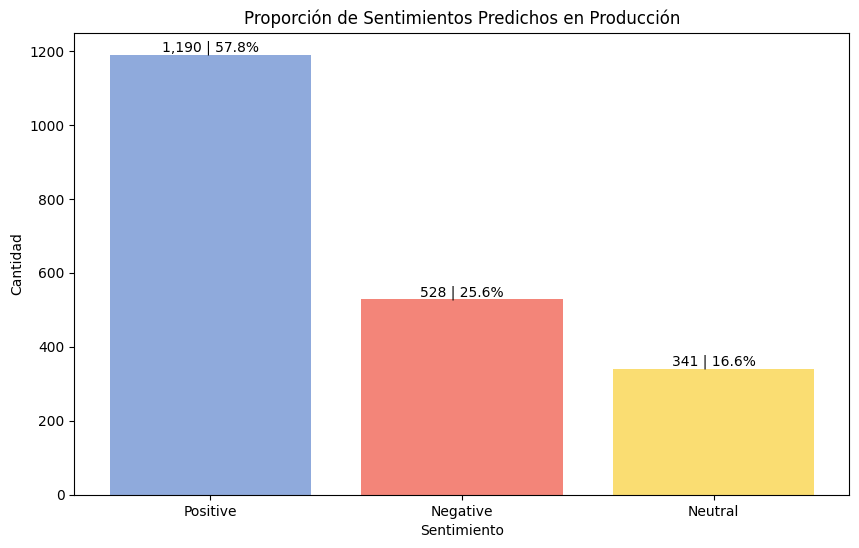

In [7]:

### VISUALIZACIÓN DE RESULTADOS EN PRODUCCIÓN ###

# Definir colores para cada sentimiento
sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}

# Crear un gráfico de barras para las proporciones de sentimientos
plt.figure(figsize=(10, 6))
# Calculate the counts of each predicted sentiment
production_sentiment_counts = produccion_dataset['predicted_sentiment'].value_counts()

# Create the bar plot
production_bars = plt.bar(
    production_sentiment_counts.index,
    production_sentiment_counts,
    color=[sentiment_colors[sentiment] for sentiment in production_sentiment_counts.index]
)

# Add percentage labels on top of each bar
for rect in production_bars:
    height = rect.get_height()
    percentage = (height / production_sentiment_counts.sum()) * 100
    plt.text(rect.get_x() + rect.get_width()/2., height,
             f'{height:,.0f} | {percentage:.1f}%',
             ha='center', va='bottom')

plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Proporción de Sentimientos Predichos en Producción')
plt.xticks(production_sentiment_counts.index, production_sentiment_counts.index)
plt.show()




## 7. Categorización de Tópicos

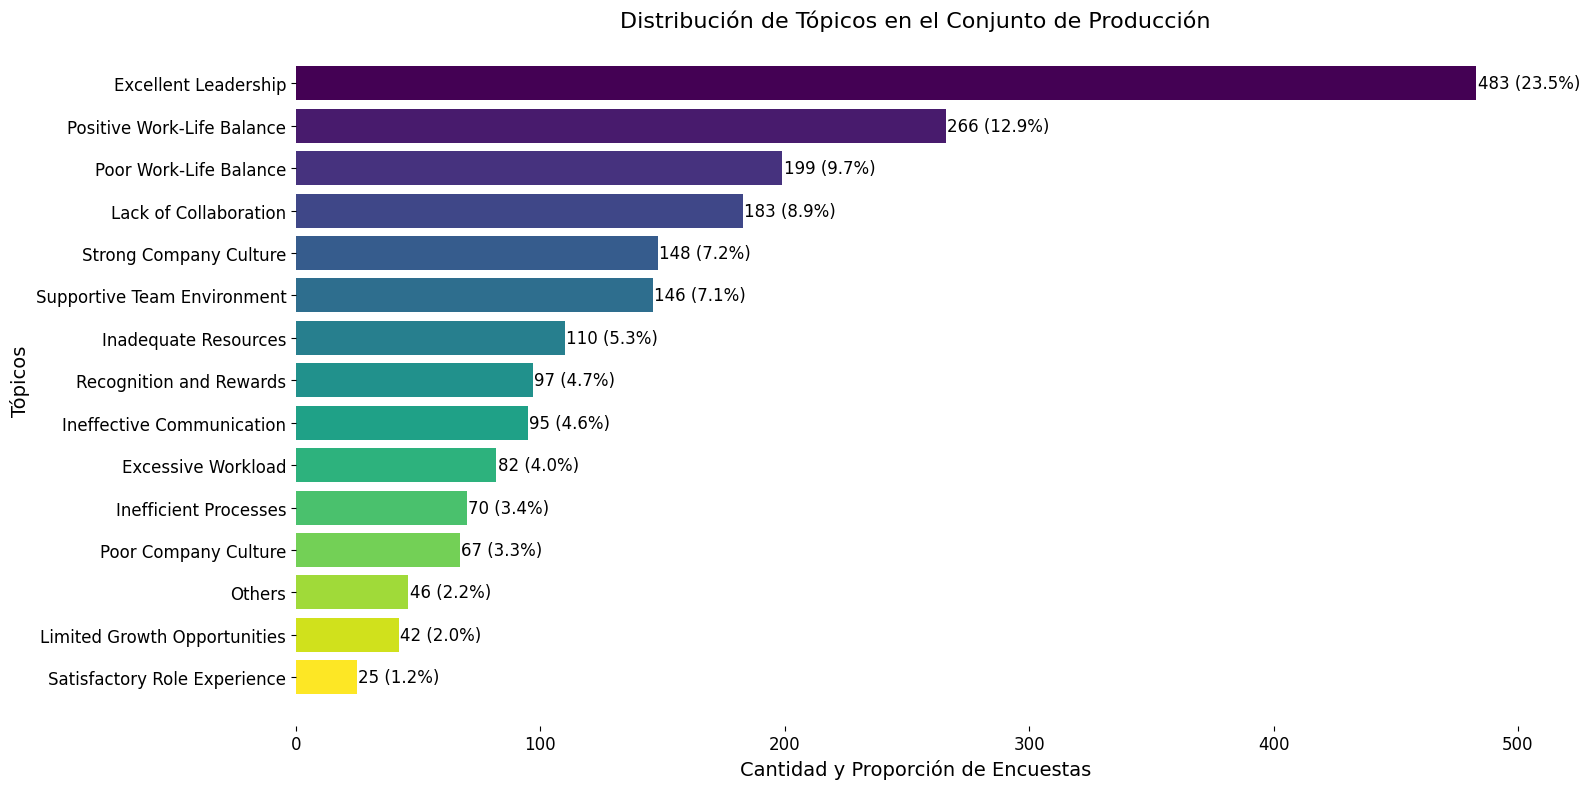

In [8]:

lemmatizer = WordNetLemmatizer()

# Definición de los problemas predefinidos (Estos son solo ejemplos, se pueden agregar más problemas y palabras clave si es necesario para entrenar el modelo)
predefined_issues = {
    "Poor Work-Life Balance": ["work-life", "overtime", "hours", "balance", "poor", "awful", "terrible", "unacceptable"],
    "Excessive Workload": ["overworked", "tense", "stressed", "burned out", "exhausted", "pressured", "anxious", "workload"],
    "Inadequate Resources": ["inadequate", "resources", "support", "perform", "effectively", "tools", "insufficient"],
    "Poor Company Culture": ["culture", "morale", "low", "poor", "declining", "concerning", "needs improvement"],
    "Limited Growth Opportunities": ["growth", "opportunities", "limited", "lacking", "insufficient", "advancement"],
    "Ineffective Communication": ["communication", "poor", "inadequate", "lacking", "insufficient", "management"],
    "Inefficient Processes": ["processes", "efficient", "adequate", "reasonable", "satisfactory", "okay"],
    "Lack of Collaboration": ["collaboration", "team", "dynamics", "standard", "average", "alright", "fine"],
    "Excellent Leadership": ["leadership", "excellent", "outstanding", "fantastic", "great", "management", "clear"],
    "Supportive Team Environment": ["team", "collaborative", "supportive", "encouraging", "helpful", "unit", "group"],
    "Positive Work-Life Balance": ["work-life", "balance", "excellent", "wonderful", "exceptional", "superior"],
    "Strong Company Culture": ["culture", "excellent", "outstanding", "fantastic", "great", "management", "listens", "responds", "considers"],
    "Recognition and Rewards": ["recognized", "valued", "appreciated", "respected", "rewarded", "benefits", "compensation"],
    "Satisfactory Role Experience": ["satisfied", "role", "average", "acceptable", "responsibilities", "moderate"]
}

# Función para lematizar el texto
def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

# Función para asignar un problema basado en el comentario
def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Others"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap:
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Others"

# Supongamos que 'produccion_dataset_nn' es el DataFrame de producción filtrado por sentimientos neutrales y negativos
produccion_dataset['issue'] = produccion_dataset["response"].apply(assign_issue)

# Visualización de la clasificación de tópicos
plt.figure(figsize=(16, 8))
issue_counts = produccion_dataset['issue'].value_counts()
issue_percentages = (issue_counts / len(produccion_dataset)) * 100

# Sort in ascending order for better visualization
issue_counts_sorted = issue_counts.sort_values(ascending=True)
issue_percentages_sorted = issue_percentages[issue_counts_sorted.index]

# Create horizontal bar plot
bars = plt.barh(y=range(len(issue_counts_sorted)), 
                width=issue_counts_sorted.values,
                color=plt.cm.viridis(np.linspace(1, 0, len(issue_counts_sorted))))

# Add labels with count and percentage
for i, (value, percentage) in enumerate(zip(issue_counts_sorted.values, 
                                          issue_percentages_sorted.values)):
    plt.text(value + 0.5, i, 
             f"{int(value)} ({percentage:.1f}%)", 
             va='center', 
             fontsize=12)

plt.yticks(range(len(issue_counts_sorted)), issue_counts_sorted.index, fontsize=12)
plt.xlabel('Cantidad y Proporción de Encuestas', size=14)
plt.ylabel('Tópicos', size=14)
plt.title('Distribución de Tópicos en el Conjunto de Producción', size=16)
plt.xticks(fontsize=12)
plt.box(False)  # Elimina el marco del gráfico
plt.tight_layout()
plt.show()




## 8. Categorización de Tópicos para encuestas negativas

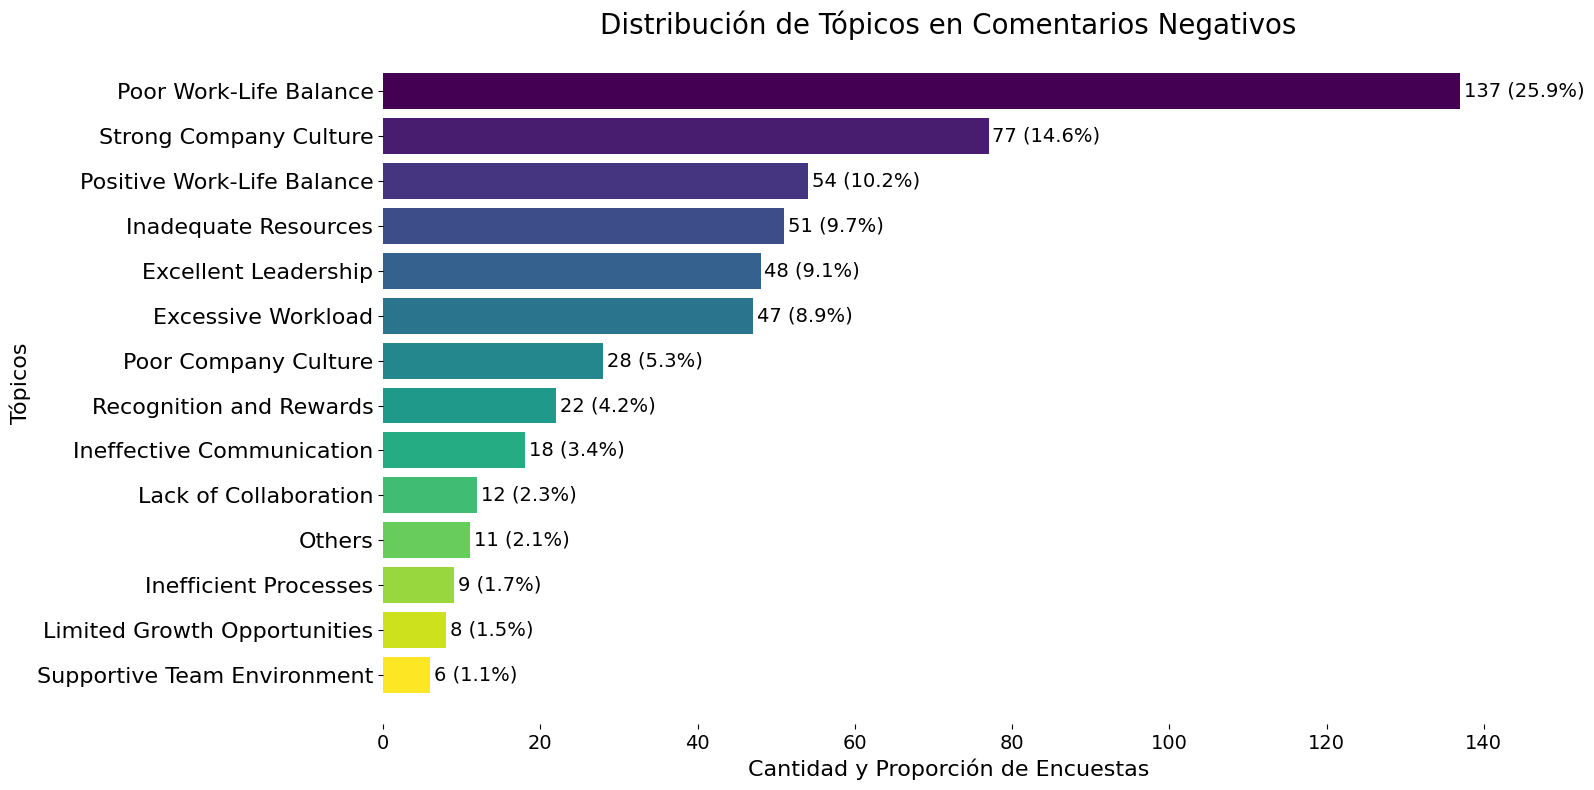


Distribución de tópicos en comentarios negativos:
                              Conteo  Porcentaje
issue                                           
Supportive Team Environment        6         1.1
Limited Growth Opportunities       8         1.5
Inefficient Processes              9         1.7
Others                            11         2.1
Lack of Collaboration             12         2.3
Ineffective Communication         18         3.4
Recognition and Rewards           22         4.2
Poor Company Culture              28         5.3
Excessive Workload                47         8.9
Excellent Leadership              48         9.1
Inadequate Resources              51         9.7
Positive Work-Life Balance        54        10.2
Strong Company Culture            77        14.6
Poor Work-Life Balance           137        25.9


In [9]:
# Filtrar solo los casos negativos
negative_cases = produccion_dataset[produccion_dataset['predicted_sentiment'] == 'Negative']

# Calcular las proporciones de issues para casos negativos
issue_proportions = negative_cases['issue'].value_counts()
issue_percentages = (issue_proportions / len(negative_cases)) * 100

# Ordenar por proporción ascendente
issue_proportions_sorted = issue_proportions.sort_values(ascending=True)
issue_percentages_sorted = issue_percentages[issue_proportions_sorted.index]

# Crear visualización con paleta viridis invertida
plt.figure(figsize=(16, 8))

# Create horizontal bar plot
plt.barh(y=range(len(issue_proportions_sorted)),
         width=issue_proportions_sorted.values,
         color=plt.cm.viridis(np.linspace(1, 0, len(issue_proportions_sorted))))

# Set the y-tick labels
plt.yticks(range(len(issue_proportions_sorted)), 
          issue_proportions_sorted.index)

# Agregar etiquetas con conteo y porcentaje
for i, (value, percentage) in enumerate(zip(issue_proportions_sorted.values, 
                                          issue_percentages_sorted.values)):
    plt.text(value + 0.5, i, 
             f"{int(value)} ({percentage:.1f}%)", 
             va='center', 
             fontsize=14)

plt.ylabel('Tópicos', size=16)
plt.xlabel('Cantidad y Proporción de Encuestas', size=16)
plt.title('Distribución de Tópicos en Comentarios Negativos', size=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.box(False)  # Elimina el marco del gráfico
plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\nDistribución de tópicos en comentarios negativos:")
results_df = pd.DataFrame({
    'Conteo': issue_proportions_sorted,
    'Porcentaje': issue_percentages_sorted.round(1)
})
print(results_df)

In [10]:
produccion_dataset.head(10)

,survey_id,employee_id,survey_date,response,satisfaction_score,predicted_sentiment,issue
0,1,1001,2024-07-12,The excellent training is top-notch.,4,Positive,Excellent Leadership
1,2,1002,2022-11-02,Management considers and supports us.,4,Negative,Strong Company Culture
2,3,1002,2023-11-02,Work-life is unacceptable to manage.,2,Negative,Poor Work-Life Balance
3,4,1002,2024-11-02,The unit culture is fantastic and very inclusive.,5,Positive,Strong Company Culture
4,5,1003,2022-05-11,I appreciate how listens the team is to concerns.,5,Positive,Lack of Collaboration
5,6,1003,2023-05-11,Balance feels satisfactory often.,3,Negative,Poor Work-Life Balance
6,7,1003,2024-05-11,The exceptional support is exceptional.,4,Neutral,Inadequate Resources
7,8,1004,2022-08-13,The area is satisfactory for now.,3,Neutral,Inefficient Processes
8,9,1004,2023-08-13,The department culture is fantastic and very i...,5,Positive,Strong Company Culture
9,10,1004,2024-08-13,Work-life balance is superior daily.,5,Negative,Positive Work-Life Balance


## 9. Guardar y Cargar Modelo

In [11]:
def save_predictions_and_model():
    """Guarda el modelo NB y las predicciones de sentimiento en SQL Server"""
    
    # 1. Guardar modelo NB
    os.makedirs('Modelos Entrenados', exist_ok=True)
    model_path = 'Modelos Entrenados/sentiment_NB_model.pkl'
    joblib.dump(clf, model_path)
    print(f"Modelo NB guardado en: {model_path}")

    # 2. Guardar predicciones en SQL Server
    conn = get_db_connection()
    cursor = conn.cursor()
    timestamp = datetime.datetime.now()

    try:
        # Crear tabla Sentiment_Predictions si no existe
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'Sentiment_Predictions')
            CREATE TABLE Sentiment_Predictions (
                prediction_id INT IDENTITY(1,1),
                survey_id INT,
                prediction_date DATETIME,
                predicted_sentiment VARCHAR(20),
                issue VARCHAR(100)
            )
        """)
        
        # Insertar predicciones
        for _, row in produccion_dataset.iterrows():
            cursor.execute("""
                INSERT INTO Sentiment_Predictions 
                (survey_id, prediction_date, predicted_sentiment, issue)
                VALUES (%s, %s, %s, %s)
            """, (
                row['survey_id'],
                timestamp,
                row['predicted_sentiment'],
                row['issue']
            ))
        
        conn.commit()
        logging.info("Predicciones de sentimiento guardadas exitosamente")
        
        # Mostrar resumen
        print("\nResumen de predicciones guardadas:")
        print("-" * 70)
        sentiment_counts = produccion_dataset['predicted_sentiment'].value_counts()
        issue_counts = produccion_dataset['issue'].value_counts()
        
        print("\nDistribución de Sentimientos:")
        for sentiment, count in sentiment_counts.items():
            print(f"{sentiment}: {count} ({count/len(produccion_dataset)*100:.1f}%)")
        
        print("\nDistribución de Issues:")
        for issue, count in issue_counts.items():
            print(f"{issue}: {count} ({count/len(produccion_dataset)*100:.1f}%)")
        
    except Exception as e:
        conn.rollback()
        logging.error(f"Error guardando predicciones: {e}")
        raise
    finally:
        conn.close()

# Ejecutar guardado
try:
    save_predictions_and_model()
    print("\nModelo y predicciones guardados exitosamente.")
except Exception as e:
    print(f"\nError durante el guardado: {str(e)}")

# Verificar registros
def verify_sentiment_predictions():
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT COUNT(*) FROM Sentiment_Predictions")
        count = cursor.fetchone()[0]
        print(f"\nRegistros en Sentiment_Predictions: {count}")
    except Exception as e:
        print(f"Error verificando tabla: {e}")
    finally:
        conn.close()

verify_sentiment_predictions()

Modelo NB guardado en: Modelos Entrenados/sentiment_NB_model.pkl


INFO:root:Predicciones de sentimiento guardadas exitosamente



Resumen de predicciones guardadas:
----------------------------------------------------------------------

Distribución de Sentimientos:
Positive: 1190 (57.8%)
Negative: 528 (25.6%)
Neutral: 341 (16.6%)

Distribución de Issues:
Excellent Leadership: 483 (23.5%)
Positive Work-Life Balance: 266 (12.9%)
Poor Work-Life Balance: 199 (9.7%)
Lack of Collaboration: 183 (8.9%)
Strong Company Culture: 148 (7.2%)
Supportive Team Environment: 146 (7.1%)
Inadequate Resources: 110 (5.3%)
Recognition and Rewards: 97 (4.7%)
Ineffective Communication: 95 (4.6%)
Excessive Workload: 82 (4.0%)
Inefficient Processes: 70 (3.4%)
Poor Company Culture: 67 (3.3%)
Others: 46 (2.2%)
Limited Growth Opportunities: 42 (2.0%)
Satisfactory Role Experience: 25 (1.2%)

Modelo y predicciones guardados exitosamente.

Registros en Sentiment_Predictions: 2059
